In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid", palette="magma")
plt.style.use('ggplot')

np.random.seed(42)

# Load data

In [3]:
df = pd.read_csv('../dataset/star_classification_train.csv')
df.sample(5)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID,class
89610,1.237680e+18,20.289802,-7.457719,21.00430,20.36410,20.06330,19.88517,19.55661,8095,301,3,434,8.060337e+18,2.100584,7159,56603,72,QSO
12456,1.237661e+18,207.692427,44.821522,22.81491,22.20049,20.46211,19.45827,19.11140,3699,301,3,127,7.462472e+18,0.599900,6628,56366,27,GALAXY
53403,1.237679e+18,339.061828,4.668577,21.51055,21.56060,21.41343,20.90284,20.65224,7765,301,4,183,1.277133e+19,1.758967,11343,58430,909,QSO
62905,1.237665e+18,200.977083,32.793846,18.69354,17.29694,16.68242,16.42502,16.29986,4576,301,1,537,3.802316e+18,-0.000299,3377,54950,551,STAR
66339,1.237658e+18,123.410424,38.343975,19.31456,19.13036,19.46549,19.71126,20.06288,2822,301,6,127,4.284152e+18,-0.000012,3805,55269,374,STAR


In [4]:
df.dtypes

obj_ID         float64
alpha          float64
delta          float64
u              float64
g              float64
r              float64
i              float64
z              float64
run_ID           int64
rerun_ID         int64
cam_col          int64
field_ID         int64
spec_obj_ID    float64
redshift       float64
plate            int64
MJD              int64
fiber_ID         int64
class           object
dtype: object

### Set data types

In [5]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
df[numerical_columns] = df[numerical_columns].astype('float64')
df['class'] = df['class'].astype('category')
df.dtypes

obj_ID          float64
alpha           float64
delta           float64
u               float64
g               float64
r               float64
i               float64
z               float64
run_ID          float64
rerun_ID        float64
cam_col         float64
field_ID        float64
spec_obj_ID     float64
redshift        float64
plate           float64
MJD             float64
fiber_ID        float64
class          category
dtype: object

### Encode class

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])
df['class'].value_counts()

class
0    53500
2    19435
1    17065
Name: count, dtype: int64

## Lets make a new feature

In [7]:
df['intensity'] = df['g']+ df['r']+ df['i']+ df['z']+ df['u']
df['intensity'].describe()

count    90000.000000
mean        99.880911
std        100.596836
min     -29960.817650
25%         93.107655
50%        102.784080
75%        107.094977
max        137.714580
Name: intensity, dtype: float64

## Feature variances

In [8]:
df.var().sort_values(ascending=False)

spec_obj_ID    1.104043e+37
obj_ID         7.117705e+25
plate          8.709265e+06
run_ID         3.858552e+06
MJD            3.269689e+06
fiber_ID       7.432344e+04
field_ID       2.231064e+04
intensity      1.011972e+04
alpha          9.298274e+03
u              1.120860e+03
g              1.119629e+03
z              1.118182e+03
delta          3.858602e+02
r              3.439559e+00
i              3.088624e+00
cam_col        2.519085e+00
class          6.671341e-01
redshift       5.337491e-01
rerun_ID       0.000000e+00
dtype: float64

### Normalization and split

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='class').values
y = df['class'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

X_train.shape, X_valid.shape

((81000, 18), (9000, 18))

## Contributions to principal components

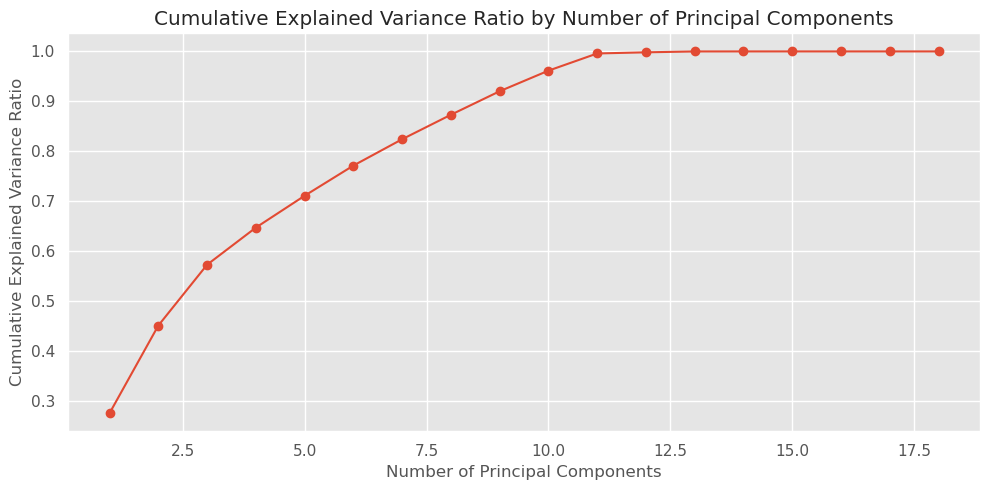

In [11]:
from sklearn.decomposition import PCA

scaler_pca = StandardScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

X = df.iloc[:, :-1]
pca = PCA()
pca.fit(X)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.tight_layout()
plt.show()

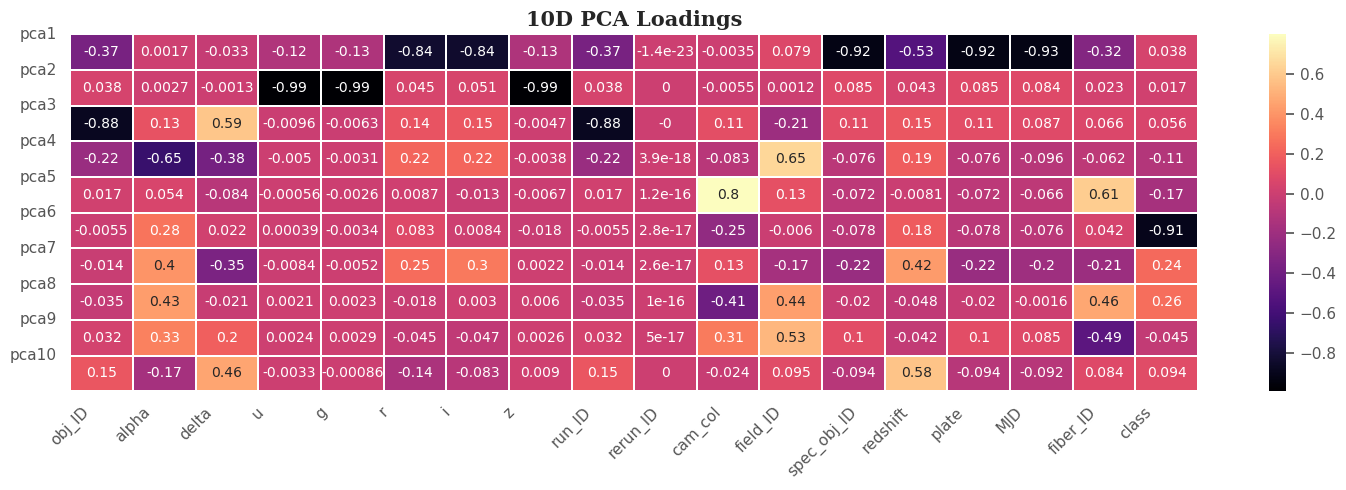

In [12]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10'])
df_pca['class'] = df['class']

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

plt.figure(figsize=(15, 5))
sns.heatmap(loadings.T, cmap='magma', annot=True, linewidths=0.1, linecolor='white')
plt.xticks(range(len(df.columns) - 1), df.columns[:-1], rotation=45)
plt.yticks(range(10), ['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10'], rotation=0)
plt.title('10D PCA Loadings', fontsize=15, fontfamily='serif', fontweight='bold')
plt.tight_layout()
plt.show()

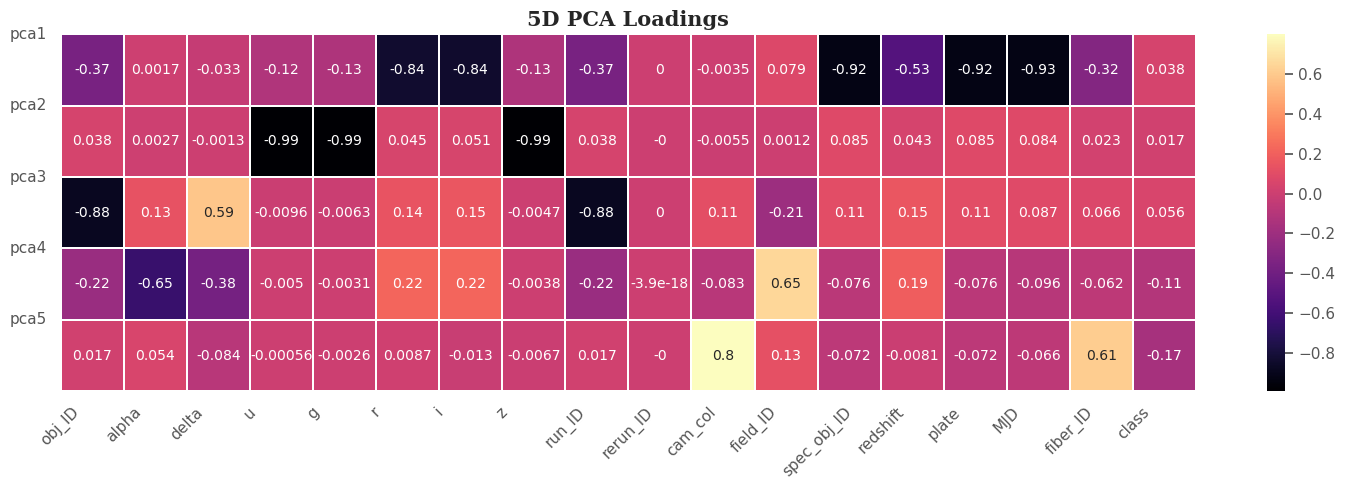

In [13]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['pca1', 'pca2', 'pca3', 'pca4', 'pca5'])
df_pca['class'] = df['class']

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

plt.figure(figsize=(15, 5))
sns.heatmap(loadings.T, cmap='magma', annot=True, linewidths=0.1, linecolor='white')
plt.xticks(range(len(df.columns) - 1), df.columns[:-1], rotation=45)
plt.yticks(range(5), ['pca1', 'pca2', 'pca3', 'pca4', 'pca5'], rotation=0)
plt.title('5D PCA Loadings', fontsize=15, fontfamily='serif', fontweight='bold')
plt.tight_layout()
plt.show()

## Regularization

C=0.01, Accuracy: 0.8228888888888889
C=0.1, Accuracy: 0.8274444444444444
C=1, Accuracy: 0.8275555555555556
C=10, Accuracy: 0.8276666666666667
C=100, Accuracy: 0.8276666666666667
C=1000, Accuracy: 0.8276666666666667


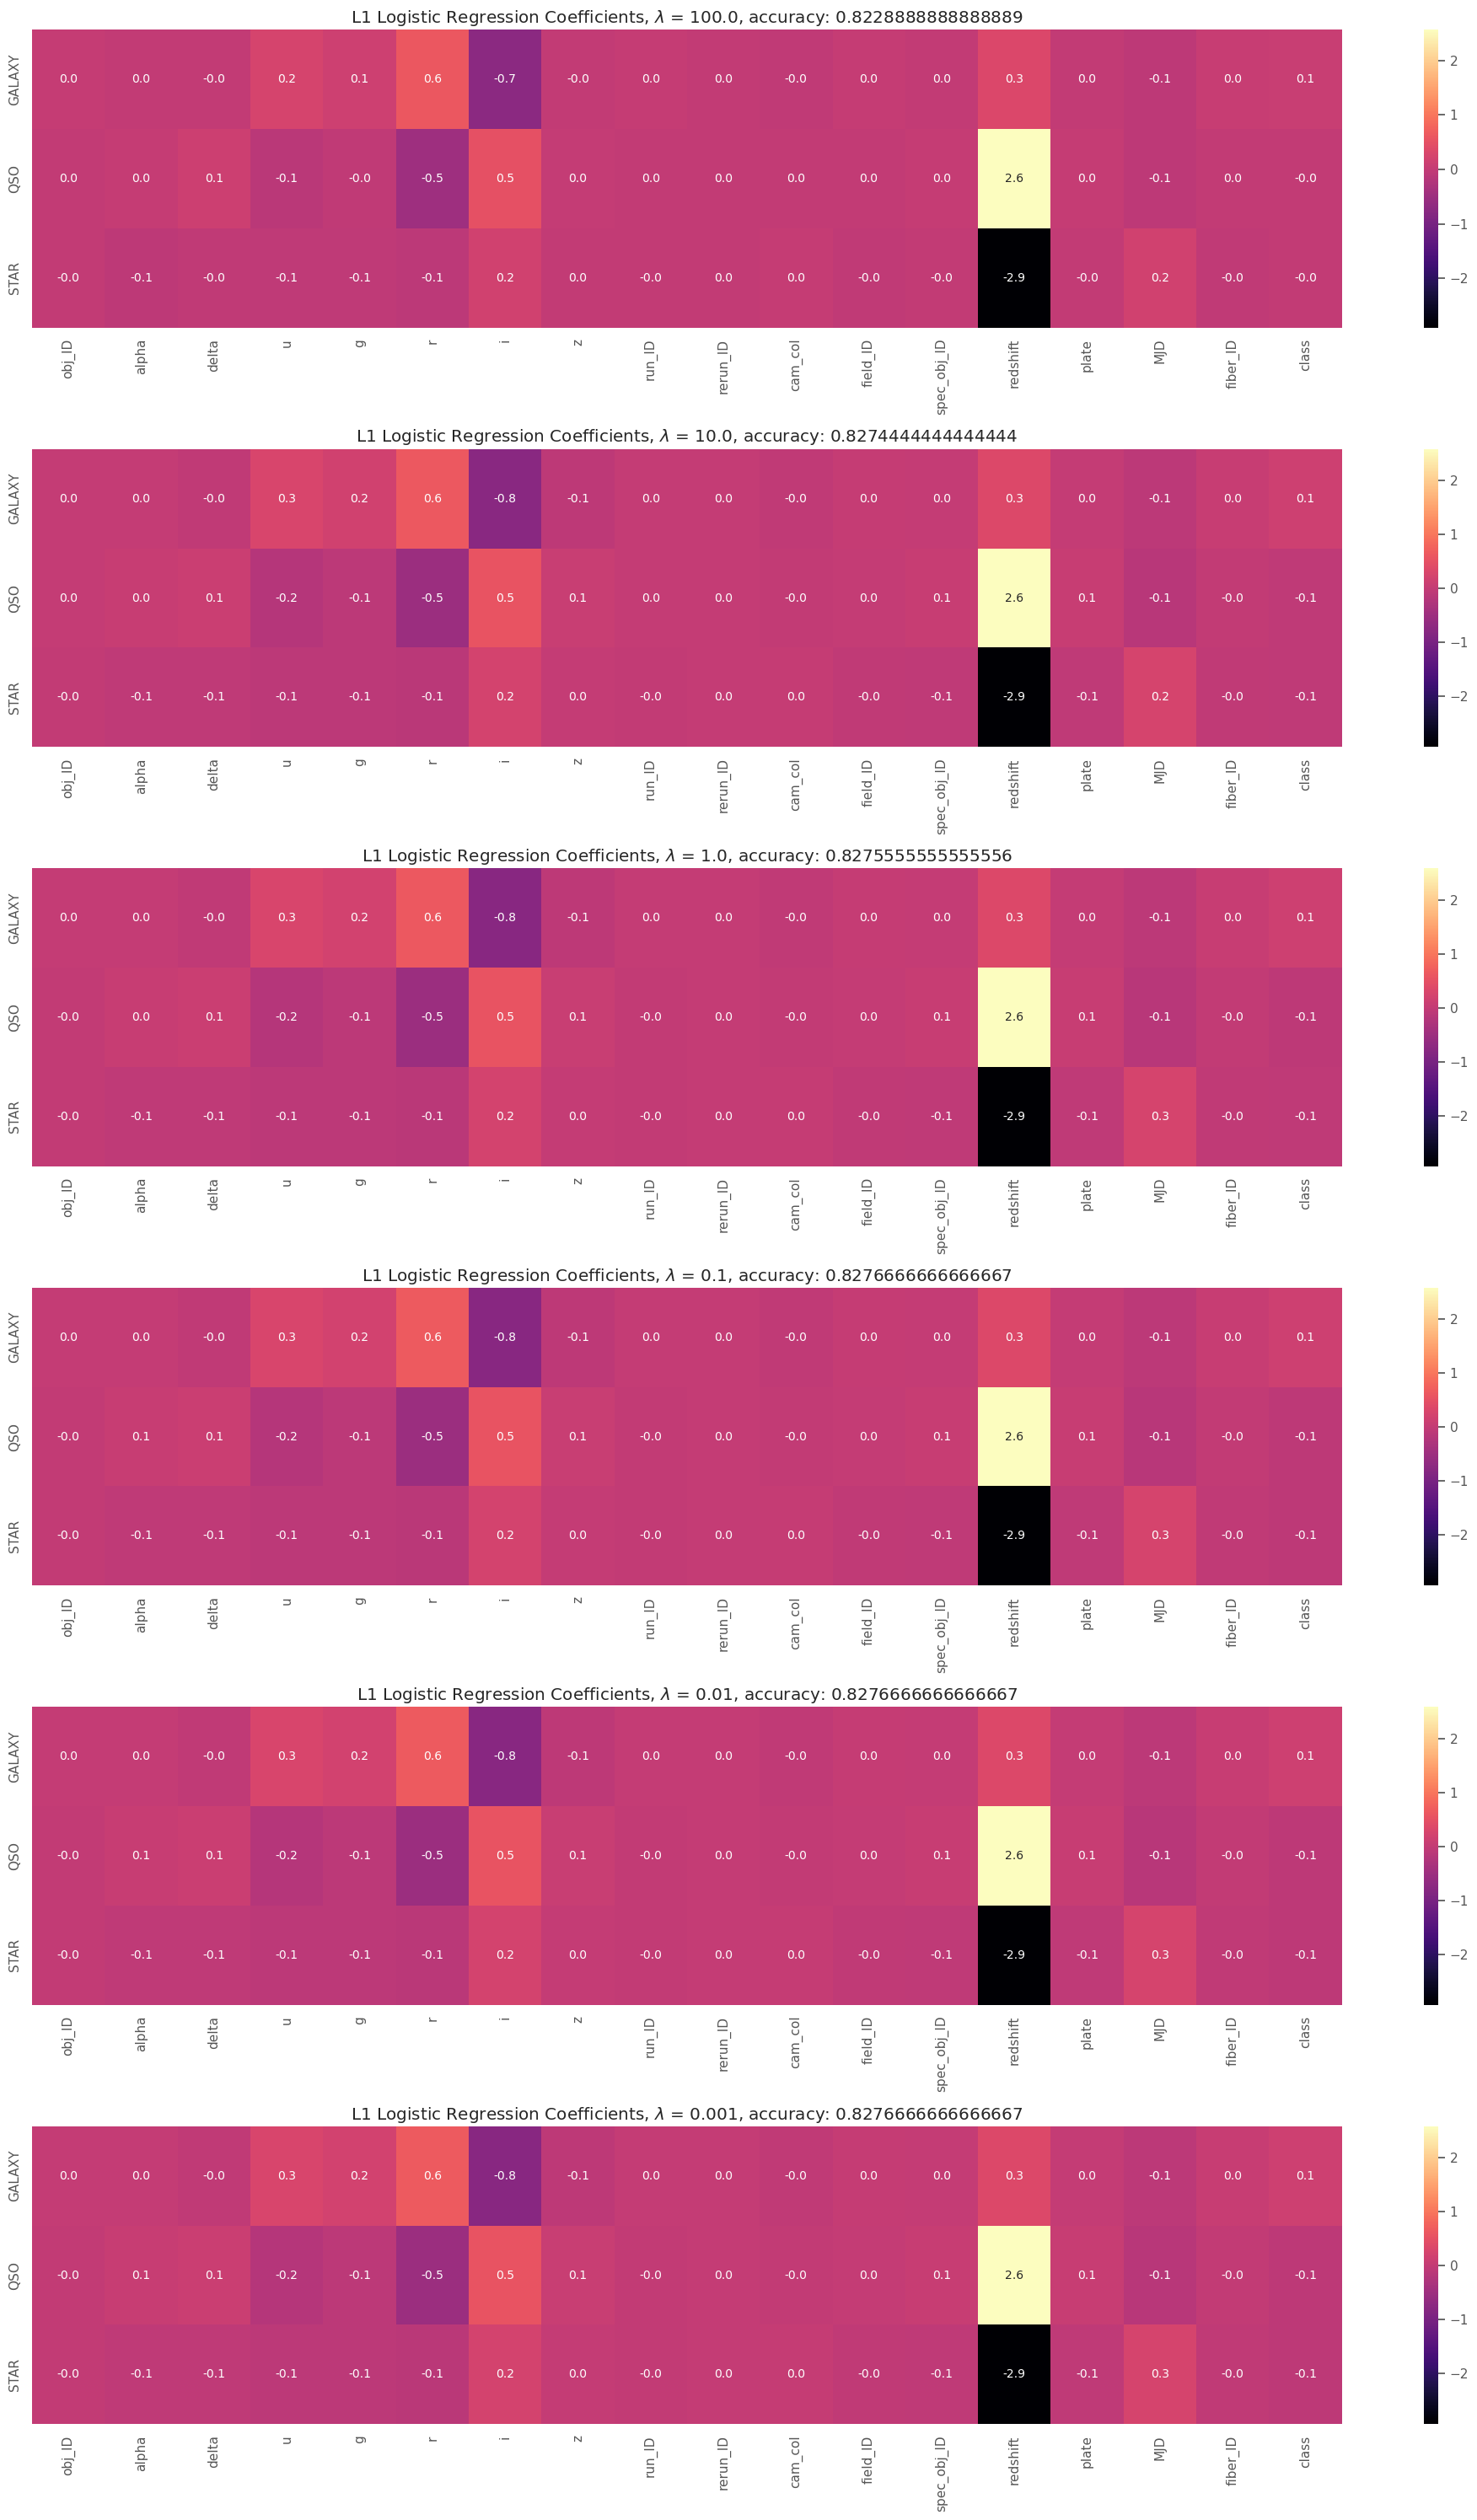

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

c_values = [0.01, 0.1, 1, 10, 100, 1000]

fig, ax = plt.subplots(len(c_values), 1, figsize=(20, 30))

for i, c in enumerate(c_values):
    lr_multinomial = LogisticRegression(penalty='l1', class_weight='balanced', C=c, solver='saga', multi_class='multinomial', random_state=42)
    lr_multinomial.fit(X_train, y_train)
    y_pred = lr_multinomial.predict(X_valid)
    print(f'C={c}, Accuracy: {accuracy_score(y_valid, y_pred)}')
    sns.heatmap(lr_multinomial.coef_, annot=True, fmt='.1f', cmap='magma', xticklabels=df.columns[:-1], yticklabels=le.classes_, ax=ax[i])
    ax[i].set_title(f'L1 Logistic Regression Coefficients, $\lambda$ = {1/c}, accuracy: {accuracy_score(y_valid, y_pred)}')
    
plt.tight_layout()
plt.show()

C=0.01, Accuracy: 0.9294444444444444
C=0.1, Accuracy: 0.9513333333333334
C=1, Accuracy: 0.952
C=10, Accuracy: 0.9516666666666667
C=100, Accuracy: 0.9497777777777778
C=1000, Accuracy: 0.9514444444444444


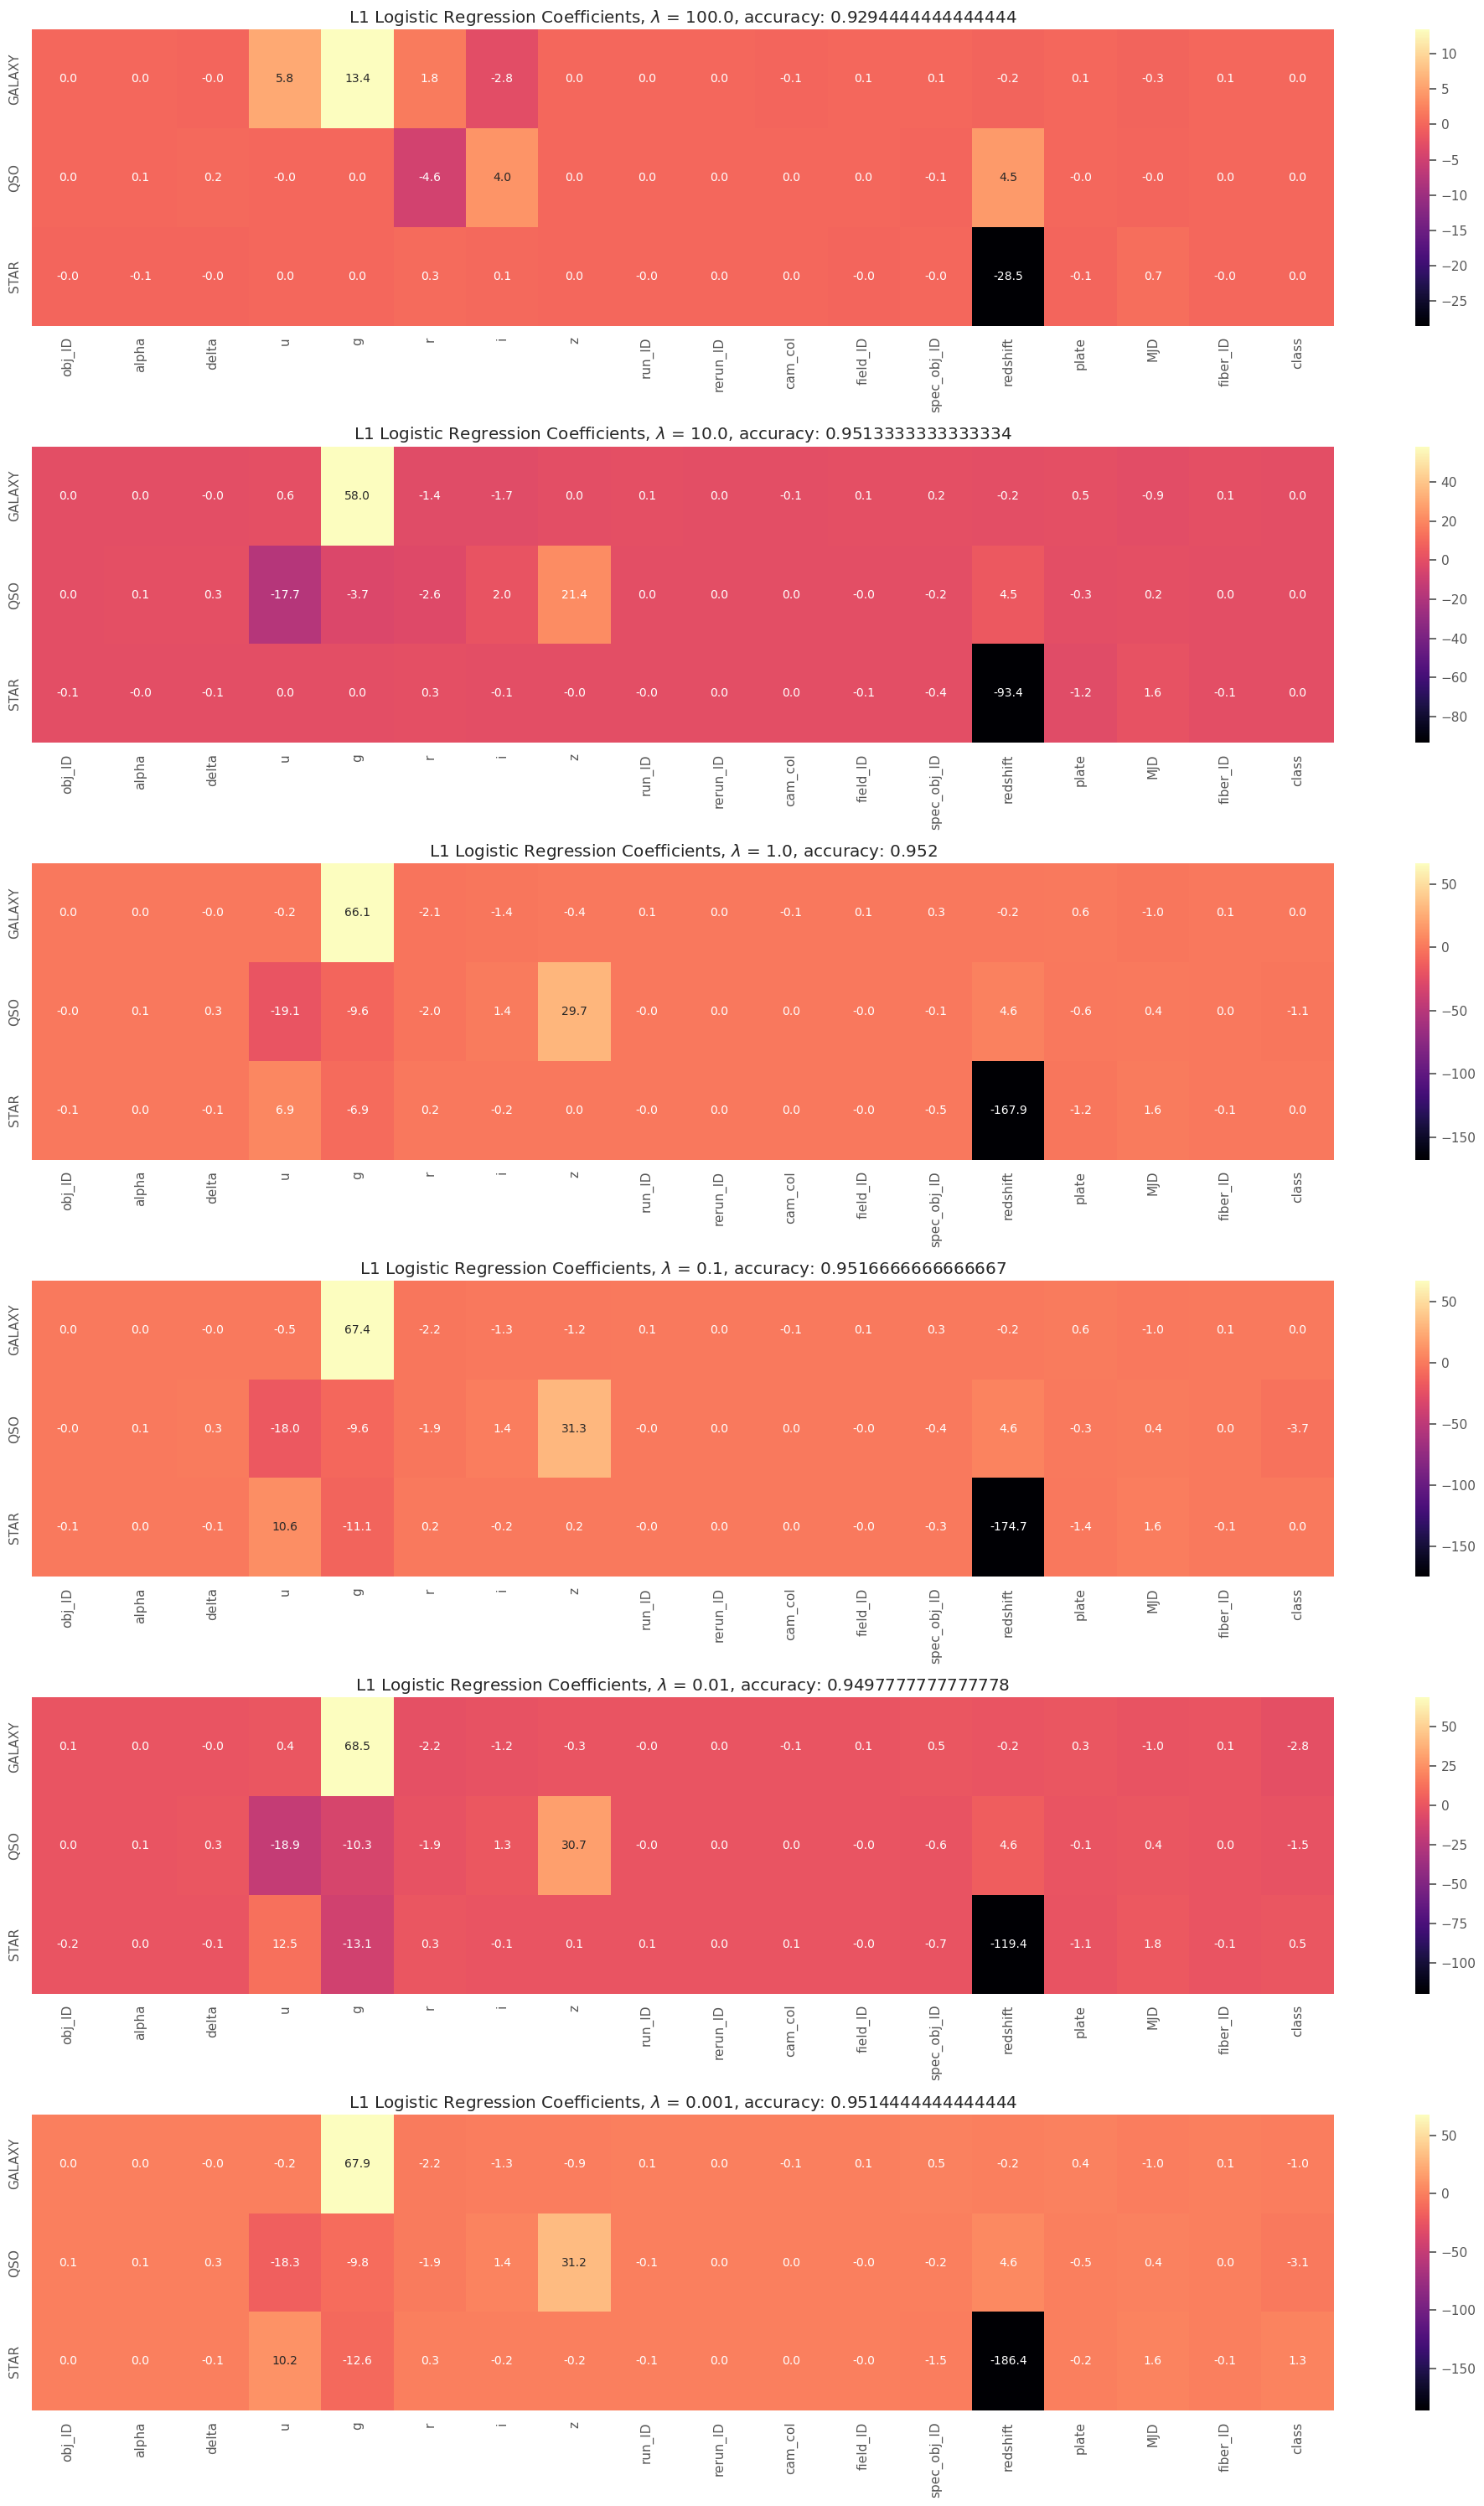

In [15]:
fig, ax = plt.subplots(len(c_values), 1, figsize=(20, 30))

for i, c in enumerate(c_values):
    lr_ovr = LogisticRegression(penalty='l1', class_weight='balanced', C=c, solver='liblinear', multi_class='ovr', random_state=42)
    lr_ovr.fit(X_train, y_train)
    y_pred = lr_ovr.predict(X_valid)
    print(f'C={c}, Accuracy: {accuracy_score(y_valid, y_pred)}')
    sns.heatmap(lr_ovr.coef_, annot=True, fmt='.1f', cmap='magma', xticklabels=df.columns[:-1], yticklabels=le.classes_, ax=ax[i])
    ax[i].set_title(f'L1 Logistic Regression Coefficients, $\lambda$ = {1/c}, accuracy: {accuracy_score(y_valid, y_pred)}')
    
plt.tight_layout()
plt.show()

Redshift has a huge impact on predictability of the class. It is the most important feature in the dataset.

## Lets explore the performance of a decision tree on the dataset with new feature

              precision    recall  f1-score   support

           0      0.971     0.970     0.970      5350
           1      0.910     0.914     0.912      1707
           2      0.996     0.994     0.995      1943

    accuracy                          0.965      9000
   macro avg      0.959     0.959     0.959      9000
weighted avg      0.965     0.965     0.965      9000


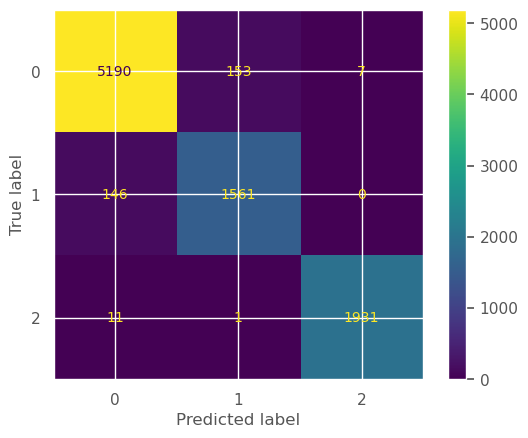

In [16]:
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

clf = tree.DecisionTreeClassifier(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)
print(classification_report(y_valid, y_pred, digits=3))
cm = confusion_matrix(y_valid, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

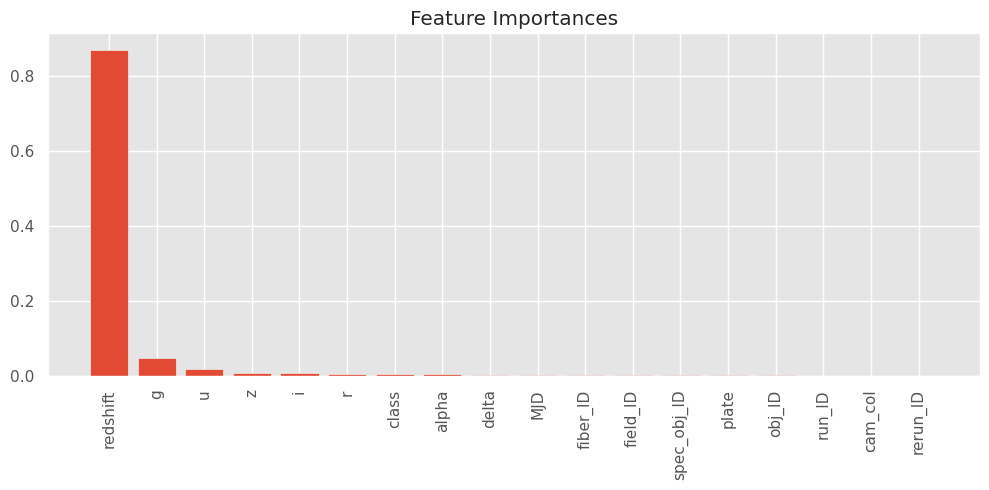

In [17]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), df.columns[:-1][indices], rotation=90)
plt.tight_layout()
plt.show()

# Time to grow more trees with random forest!

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_valid)
print(f'Accuracy: {accuracy_score(y_valid, y_pred)}')

Accuracy: 0.9792222222222222


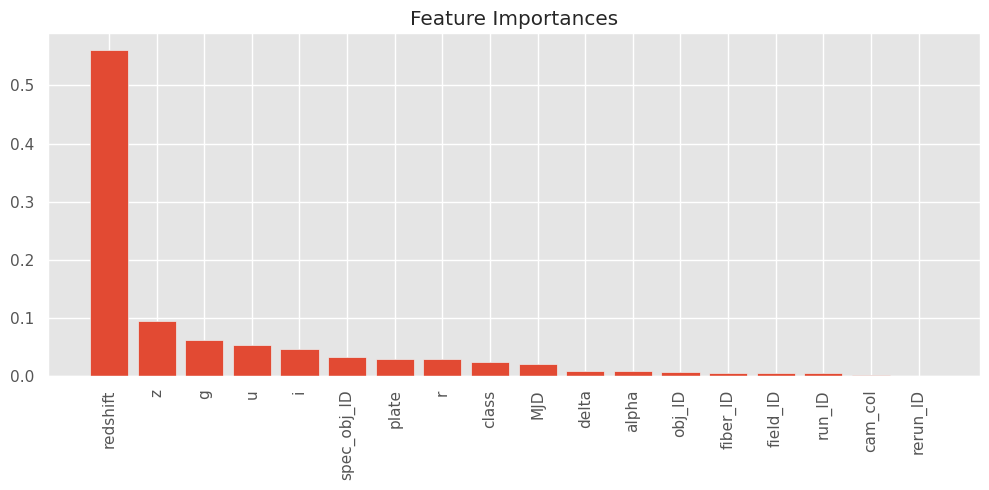

In [19]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), df.columns[:-1][indices], rotation=90)
plt.tight_layout()
plt.show()

## Set a treshold

In [21]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(tree.DecisionTreeClassifier(random_state=42), threshold=0.005)
sfm.fit(X_train, y_train)

selected_features = df.columns[:-1][sfm.get_support()]
selected_features

Index(['u', 'g', 'r', 'i', 'z', 'redshift', 'class'], dtype='object')

### Does it improve predictability?

              precision    recall  f1-score   support

           0      0.968     0.970     0.969      5350
           1      0.910     0.906     0.908      1707
           2      0.995     0.996     0.996      1943

    accuracy                          0.963      9000
   macro avg      0.958     0.957     0.958      9000
weighted avg      0.963     0.963     0.963      9000


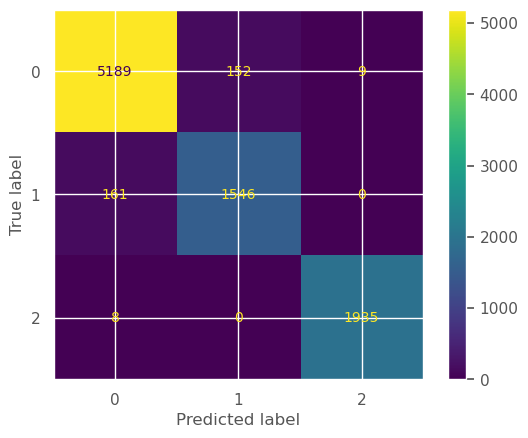

In [23]:
from sklearn.pipeline import Pipeline

clf = tree.DecisionTreeClassifier(random_state=42)
# clf = RandomForestClassifier(n_estimators=100)
sfm = SelectFromModel(tree.DecisionTreeClassifier(random_state=42), threshold=0.005)
pipeline = Pipeline(steps=[
    ('feature_selection', sfm),
    ('classifier', clf)
])

pipeline.fit(X_train, y_train.ravel())
y_pred = pipeline.predict(X_valid)
print(classification_report(y_valid, y_pred, digits=3))
cm = confusion_matrix(y_valid, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

to do: grid search

In [ ]:
# grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30]}
# clf = RandomForestClassifier()
# clf = GridSearchCV(clf, grid, cv=3, n_jobs=-1)
# clf = clf.fit(X_train, y_train)
# print(clf.best_params_)
# y_pred = clf.predict(X_val)
# print(classification_report(y_val, y_pred, digits=3))

## Let's inspect the ROC curve

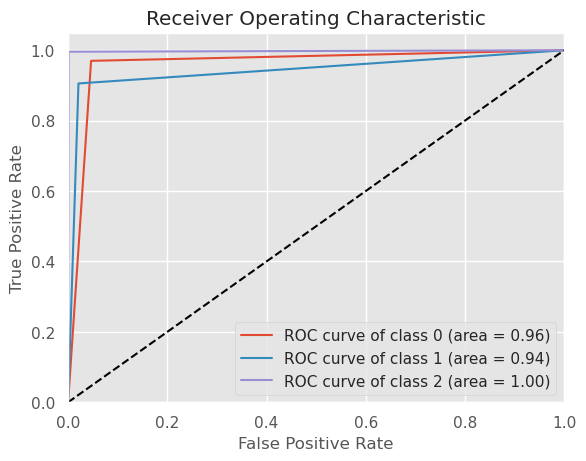

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

# for one tree model only 3 points
classes = pipeline.classes_
y_prob = pipeline.predict_proba(X_valid)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_valid == classes[i], y_prob[:,i])
    roc_auc[i] = roc_auc_score(y_valid == classes[i], y_prob[:,i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

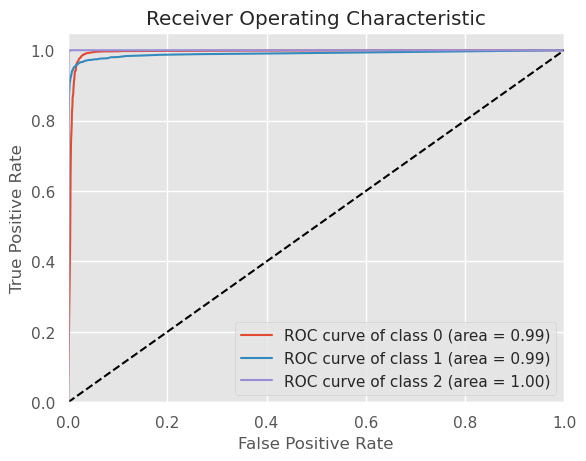

In [26]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
classes = clf.classes_
y_prob = clf.predict_proba(X_valid)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_valid == classes[i], y_prob[:,i])
    roc_auc[i] = roc_auc_score(y_valid == classes[i], y_prob[:,i])
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()